# Compound data acquisition (ChEMBL)

## The notebook is from the TeachOpenCADD talktorial 1

## Requiremnets
!pip install rdkit pandas tqdm chembl-webresource-client.new-client datamol

In [144]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm
import datamol as dm
import seaborn as sns
from rdkit import Chem
import mols2grid
import os

In [158]:

# Make a path to current directory
PATH = Path(_dh[-1]) 

protein_target = "HDAC1"
#Making a new directory to save the ChEMBL data
directory = PATH / f'{protein_target}_ChEMBL_prepared_data'
if not os.path.exists(directory):
    os.makedirs(directory)


In [34]:
# Create resource objects for ChEMBL API
targets_api = new_client.target
compound_api = new_client.molecule
bioactivity_api = new_client.activity

type(targets_api), type(compound_api), type(bioactivity_api)

(chembl_webresource_client.query_set.QuerySet,
 chembl_webresource_client.query_set.QuerySet,
 chembl_webresource_client.query_set.QuerySet)

In [35]:
# making a query to get data from ChEMBL using a uniprot ID for the target protein
uniprot_id = "Q13547" #HDAC1

# Get protein target information from the ChEMBL API with restrictions on specific values
targets_df = targets_api.get(target_components__accession=uniprot_id).only("target_chembl_id", 
                                                                        "organism", 
                                                                        "pref_name", 
                                                                        "target_type")

# NOTE This only saves the a query in a variable. 

In [37]:
# Download the data from ChEMBL using the query variable
targets = pd.DataFrame(targets_df)
# Head is only used for this notebook. Might need to view all the data to choose which target_chembl_id protein you want to use.
# For ML models that determine drug activity a single protein target type is generally preferred
targets.head()

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Histone deacetylase 1,CHEMBL325,SINGLE PROTEIN
1,Homo sapiens,Histone deacetylase,CHEMBL2093865,PROTEIN FAMILY
2,Homo sapiens,Histone deacetylase (HDAC1 and HDAC2),CHEMBL2111429,PROTEIN FAMILY
3,Homo sapiens,Histone deacetylase 1/3/5/8,CHEMBL3038483,PROTEIN FAMILY
4,Homo sapiens,Histone deacetylase 1/2/3/6,CHEMBL3430896,PROTEIN FAMILY


In [38]:
# Obtain the chembl_id for the target using the name of the protein
chembl_id = targets.loc[targets["target_chembl_id"] == "CHEMBL325", "target_chembl_id"].values[0]

# Obtain the chembl_id for the target the positon of the taget in the targets database
target = targets.iloc[0]
chembl_id = target["target_chembl_id"]

chembl_id

'CHEMBL325'

In [40]:
# Making query to get the bioactivity data from the Chembl API for the target protein
bioactivity = bioactivity_api.filter(target_chembl_id=chembl_id,
                                     type="IC50", # Determine the type of bioactivity. Keep the same type. Do not mix Ki and IC50, etc.
                                     relation="=", # The bioactivity must be exactly a interger. It can't be a range .e.g > 40 uM
                                     assay_type="B" # Binding assay is B
                                     ).only("activity_id",
                                            "activity_id",
                                            "assay_chembl_id",
                                            "assay_description",
                                            "assay_type",
                                            "molecule_chembl_id",
                                            "type",
                                            "standard_units",
                                            "relation",
                                            "standard_value",
                                            "target_chembl_id",
                                            "target_organism",
                                            )

# Looking at number of bioactivity data points to be downloaded and information of first entry
print(f"Length and type of bioactivities object: {len(bioactivity)}, {type(bioactivity)}")

print(f"Length and type of first element: {len(bioactivity[0])}, {type(bioactivity[0])}")
bioactivity[0]

Length and type of bioactivities object: 7097, <class 'chembl_webresource_client.query_set.QuerySet'>
Length and type of first element: 13, <class 'dict'>


{'activity_id': 114830,
 'assay_chembl_id': 'CHEMBL701994',
 'assay_description': 'Inhibitory activity against human Histone deacetylase 1',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL323869',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '2.5',
 'target_chembl_id': 'CHEMBL325',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'nM',
 'value': '2.5'}

In [88]:
#Download the data from ChEMBL using the query variable
bioactivity_df = pd.DataFrame(bioactivity)
print(f"DataFrame shape: {bioactivity_df.shape}")
bioactivity_df.head()

DataFrame shape: (7097, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,114830,CHEMBL701994,Inhibitory activity against human Histone deac...,B,CHEMBL323869,=,nM,2.5,CHEMBL325,Homo sapiens,IC50,nM,2.5
1,121066,CHEMBL701994,Inhibitory activity against human Histone deac...,B,CHEMBL327146,=,nM,1.0,CHEMBL325,Homo sapiens,IC50,nM,1.0
2,130009,CHEMBL701994,Inhibitory activity against human Histone deac...,B,CHEMBL116620,=,nM,1.0,CHEMBL325,Homo sapiens,IC50,nM,1.0
3,134954,CHEMBL701994,Inhibitory activity against human Histone deac...,B,CHEMBL98,=,nM,200.0,CHEMBL325,Homo sapiens,IC50,nM,200.0
4,145537,CHEMBL701995,Inhibitory concentration against human Histone...,B,CHEMBL346414,=,nM,2000.0,CHEMBL325,Homo sapiens,IC50,uM,2.0


In [89]:
# Removing columns that give the same data.
# The standard_units and standard_values of chembl assist in the preprocessing the data
# Therefore delete value and units

#Look at the type of units from units and stadard_units columns
print(f"Standard units: {bioactivity_df['standard_units'].unique()}\nNormal units: {bioactivity_df['units'].unique()}")

# Drop the units and values columns
#bioactivity_df.drop(columns=["units", "values"], inplace=True)
#OR
bioactivity_df.drop(["units", "value"], axis=1, inplace=True) # axis = 1 means columns
bioactivity_df.head()

Standard units: ['nM']
Normal units: ['nM' 'uM' 'umol/L' "10'-7M" "10'-5M" "10'-9M" "10'-12M" "10'-6M" "10'-8M"
 '10^-7M' '10^-8M' '10^-6M' '10^-9M' 'mM']


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,114830,CHEMBL701994,Inhibitory activity against human Histone deac...,B,CHEMBL323869,=,nM,2.5,CHEMBL325,Homo sapiens,IC50
1,121066,CHEMBL701994,Inhibitory activity against human Histone deac...,B,CHEMBL327146,=,nM,1.0,CHEMBL325,Homo sapiens,IC50
2,130009,CHEMBL701994,Inhibitory activity against human Histone deac...,B,CHEMBL116620,=,nM,1.0,CHEMBL325,Homo sapiens,IC50
3,134954,CHEMBL701994,Inhibitory activity against human Histone deac...,B,CHEMBL98,=,nM,200.0,CHEMBL325,Homo sapiens,IC50
4,145537,CHEMBL701995,Inhibitory concentration against human Histone...,B,CHEMBL346414,=,nM,2000.0,CHEMBL325,Homo sapiens,IC50


### __Preprocessing and filtering the biological data for what we need__



```python
1. Convert standard_value's' datatype from object to float
2. Delete entries with missing values
3. Keep only entries with standard_unit == nM
4. Delete duplicate molecules
5. Reset DataFrame index
6. Rename columns
```




In [90]:
# Convert the standard units from objects inot floats
bioactivity_dfdf = bioactivity_df.astype({"standard_value": "float64"})

# Deleting the rows with missing values
bioactivity_df.dropna(axis=0, how="any", inplace=True)

# Removing all data other than nM
# NOTE - not needed for this particular dataset
#bioactivity_df = bioactivity_df[bioactivity_df["standard_units"] == "nM"]

# Sort by standard value 
bioactivity_df.sort_values("standard_value", inplace=True) 

# Remove any molecules with 0 nM activity
bioactivity_df['standard_value'] = pd.to_numeric(bioactivity_df['standard_value'])
bioactivity_df = bioactivity_df[bioactivity_df['standard_value'] > 0]

# Remove duplicate molecules
bioactivity_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)

# Reset index
bioactivity_df.reset_index(drop=True, inplace=True)

# Rename columns
bioactivity_df.rename(columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True)

print(f"DataFrame shape: {bioactivity_df.shape}")
bioactivity_df.head()


DataFrame shape: (5760, 11)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,15730992,CHEMBL3626708,Inhibition of HDAC1 (unknown origin),B,CHEMBL3621294,=,nM,0.00687,CHEMBL325,Homo sapiens,IC50
1,19361432,CHEMBL4422738,Inhibition of recombinant human GST-tagged HDA...,B,CHEMBL3689858,=,nM,0.01000,CHEMBL325,Homo sapiens,IC50
2,19361433,CHEMBL4422738,Inhibition of recombinant human GST-tagged HDA...,B,CHEMBL3689829,=,nM,0.02000,CHEMBL325,Homo sapiens,IC50
3,23235658,CHEMBL4828007,Inhibition of human recombinant FLAG-tagged HD...,B,CHEMBL4861467,=,nM,0.05000,CHEMBL325,Homo sapiens,IC50
4,19361434,CHEMBL4422738,Inhibition of recombinant human GST-tagged HDA...,B,CHEMBL3689834,=,nM,0.06000,CHEMBL325,Homo sapiens,IC50


### __Downloading the compounds structures and information__

```python
1. Make query for ChEMBL using the molecule_chembl_id column from bioactivity_df as molecule ID
2. Download the compound data from ChEMBL
3. Preprocess and filter compound data
    - Remove entries with missing entries
    - Delete duplicate molecules (by molecule_chembl_id)
    - Get molecules with canonical SMILES
```

In [127]:
# Make a query for compound data for ChEMBL
compound_query = compound_api.filter(
    molecule_chembl_id__in=list(bioactivity_df["molecule_chembl_id"])
    ).only("molecule_chembl_id", 
           "molecule_structures")

# Download the data from ChEMBL
compounds = list(tqdm(compound_query))
compound_df = pd.DataFrame.from_records(compounds)

# Processing the compound dataframe
# remove netries with na
compound_df.dropna(axis=0, how="any", inplace=True)

# Delete duplicate molecules
compound_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)

# Get molecules with canonical SMILES and remove any with no conanical smiles. 
# InChi keys, molfile, etc. are not gnerally used in cheminformatic analysis. RDkit can be used to convert SMILES to anything user wants
# Different represenattionsof the structure are found in the molecule_structures column
# Get canonical SMILES and save into a list
canonical_smiles = []
for i,compounds in compound_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)
# Add the SMILES to the dataframe and remove any molecule_structures column
compound_df["SMILES"] = canonical_smiles
compound_df.drop("molecule_structures", axis=1, inplace=True)
# Ensure all molecules have SMILES
compound_df.dropna(axis=0, how="any", inplace=True) #removes all rows with na

compound_df.head()

  0%|          | 0/5760 [00:00<?, ?it/s]

,molecule_chembl_id,SMILES
0,CHEMBL503,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C...
1,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO
2,CHEMBL99,CC(/C=C/C(=O)NO)=C\[C@@H](C)C(=O)c1ccc(N(C)C)cc1
3,CHEMBL14227,CCCC(=O)O
4,CHEMBL109,CCCC(CCC)C(=O)O


## __Merge the compound_df and bioactivity_df__


**Only keep columns of interest when merging**
```python
Merge columns using the molecule_chembl_id

1. ChEMBL IDs: molecule_chembl_id
2. SMILES: smiles
3. units: units
4. IC50: IC50
```

In [130]:
#Merge dataframes
database = pd.merge(bioactivity_df[["molecule_chembl_id", "IC50", "units"]], 
                    compound_df, 
                    on="molecule_chembl_id")

# reset row indexes
database.reset_index(drop=True, inplace=True)

### __Add pIC50 values to dataframe as it easier to use in ML and visualize__

In [131]:
# Converting IC50 to pIC50 and adding a new pIC50 column
# Using datamol package to convert IC50 to pIC50
database["pIC50"] = dm.molar.molar_to_log(database.IC50, "nM")

database.head()


,molecule_chembl_id,IC50,units,SMILES,pIC50
0,CHEMBL3621294,0.00687,nM,O=C(CCCCCCC(=O)Nc1ccc2c(c1)/C(=C/c1ccc[nH]1)C(...,11.163043
1,CHEMBL3689858,0.01000,nM,CCC(CC)CN(CC)Cc1c(C)nc2cc(/C=C/C(=O)NO)ccn12,11.000000
2,CHEMBL3689829,0.02000,nM,CCCCNCc1c(CCCC)nc2cc(/C=C/C(=O)NO)ccn12,10.698970
3,CHEMBL4861467,0.05000,nM,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(CC1CC1)C...,10.301030
4,CHEMBL3689834,0.06000,nM,CCCCc1nc2cc(/C=C/C(=O)NO)ccn2c1CN(CC)CCCC,10.221849


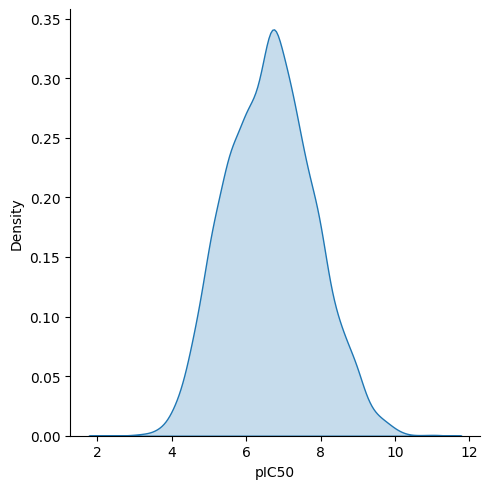

In [132]:
# Visualize the pIC50 data distribution
ax = sns.displot(database, x="pIC50", kind="kde", fill=True)

Number of actives: 4009
Number of inactives: 1743


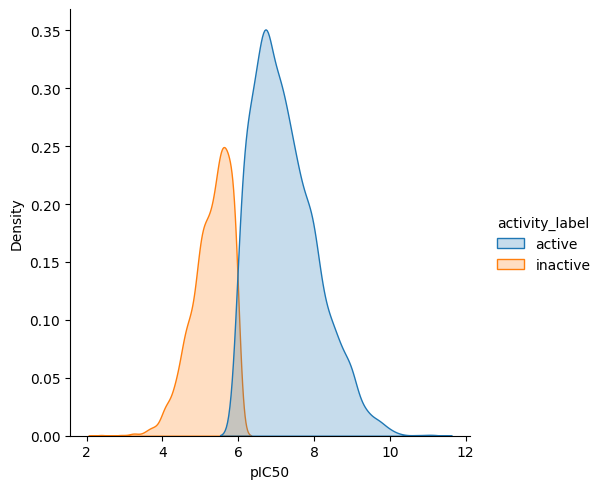

In [133]:
# Adding activity labels. 
# Active molecules are <= 1 uM using the plot above
database["activity_label"] = ["active" if x >= 6 else "inactive" for x in database["pIC50"]]
database["ML_activity_label"] = ["1" if x >= 6 else "0" for x in database["pIC50"]]
#OR
#database["ML_activity_label"] = [int(x >=6) for x in database["pIC50"]]

#show the number of actives vs inactives
print(f"Number of actives: {database[database['activity_label'] == 'active'].shape[0]}\nNumber of inactives: {database[database['activity_label'] == 'inactive'].shape[0]}")

ax = sns.displot(database, x="pIC50", hue="activity_label", kind="kde", fill=True)


In [139]:
# Sort database by pIC50
database.sort_values(by="pIC50", ascending=False, inplace=True)

# reset Row indexes
database.reset_index(drop=True, inplace=True)

# Generate rdkit molecules from smiles
database["rdkit_mol"] = database.SMILES.apply(Chem.MolFromSmiles)
# OR
PandasTools.AddMoleculeColumnToFrame(database, smilesCol="SMILES")
#Visualize compounds
mols2grid.display(database,
                  subset=["molecule_chembl_id","img", "pIC50"],
                  transform={"pIC50": lambda x: "{:.2f}".format(x)},
                  n_cols=3,
                  size=(320,240))

Failed to patch pandas - unable to change molecule rendering


MolGridWidget()

## __Save Dataframe__

In [159]:
# First remove rdkit column. One has smiles to regenerate it if needed. 
# Only do this when done with project
output_df = database.drop("ROMol", axis=1)
output_df = output_df.drop("rdkit_mol", axis=1)

#Save data
output_df.to_csv(directory / "HDAC1_ChEMBL_IC50.csv")
